In [2]:
import numpy as np 
import pandas as pd 
from astropy.io import fits
import matplotlib.pyplot as plt
from os import listdir 
from sklearn.svm import SVR
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve
from sklearn.metrics import mean_squared_error,make_scorer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#http://atlas.obs-hp.fr/elodie/sample.cgi

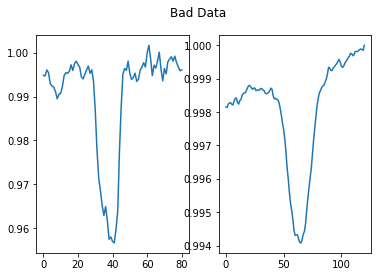

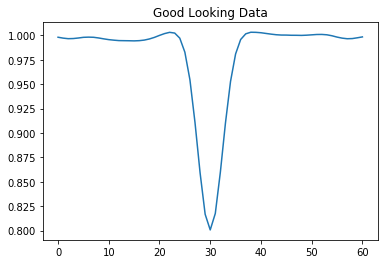

In [5]:
highSignalTooNosie = fits.open("Data/HD 82093.fits")[0].data
notNormalized = fits.open("Data/HD 80081.fits")[0].data
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Bad Data')
ax1.plot(highSignalTooNosie)
ax2.plot(notNormalized)
plt.show()

goodStar = fits.open("Data/HD 37160.fits")[0].data
plt.plot(goodStar)
plt.title("Good Looking Data")
plt.show()

In [4]:
#Importing the first 1000 lines on https://vizier.u-strasbg.fr/viz-bin/VizieR-4
stellarData = pd.read_csv("vizier_votable.tsv",sep=";")
#Depending on the method the Anstronomer uses to measure the vsini can greatly effect the vsini value
#I am only using vsini data that was measured using the Full Width Hall Max (FWHM) techinque. 
stellarData = stellarData[stellarData.Method == "FWHM"] 
#To make it easier to extract the stellar spectra from http://atlas.obs-hp.fr/elodie/ I am going to
#Make a text file that only Contains Stars in the Henry Draper (HD) Catalogue
stellarData = stellarData[stellarData.HD != "      "]
#Adding HD to the front of each data point so I can get the data from atlas
hdNames = stellarData.HD
hdNames = pd.DataFrame(["HD"+hdNumber for hdNumber in hdNames.values])
hdNames.to_csv("hdNames.txt",header=False,index=False,mode='w')

# Scaling & Splitting the Data
Both the input features, which is 120 input features along with the vsini value I normailized them both because each input feature is equally as important as any other feature.This will accelrate the learning process. Also after tests the model was having a hard time getting anywhere near the vsini values so I scaled the vsini's as well. 10% of the data will be the test data. 


In [5]:
fileNames = listdir("Data")
X = []
 #These Stars don't have enough features to be considered 
banList = []
for name in fileNames: 
    image = fits.open("Data/{}".format(name))
    if(not(image[0].data.shape[0]<121) and not(name in banList)):
        X.append(image[0].data)
    else:
        banList.append(name)
        
X = pd.DataFrame(X)
X = pd.DataFrame(scale(X))
#Getting rid of the last 20 Columns because DataPoints have diminsons of 121 and 141
#Instead of Filling in the empty cells I am removing them.
for i in range(121,167):
    X = X.drop(i,axis=1)
len(X)

197

In [6]:
y = []
for name in fileNames:
    name = name[2:len(name)-5]
    vsiniValue = stellarData[stellarData.HD == name].vsini
    if(not(("HD"+name+".fits") in banList)):
        y.append(vsiniValue.values[0])
y = scale(y)

In [7]:
#Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,shuffle=True,random_state=1)

# Models
I will be training 3 different machine learning models, because I will be using the mean squared error to evalute them and compare them to one another. For each of the models I tuned the hyper parameters by using sklearn's GridSearchCV, and for each fo the models I am setting the parameter cv = 5 to have 5-fold Cross-Validation. Since I am so limited with the amount of data I have I need to do this in order so my model can try to generalize (i.e. I can detect when the model is overfitting). Which I have found that the model does not over fit. It actually needs more data. 

**Support Vector Machine** **Overview**

When I was first thinking about making a model for finding the vsini I immediately thought that a Support Vector Machine Regressor would work best. Why? Because of it's gaussian Kernel function. Stars are almost perfect blackbodies so their light emission almost produces perfect gaussians. Thus, I thought that the rbf kernel would work the absolute best. To make sure this is true I performed a grid search with all the kernel functions and as predicted the rbf kernel function came out to be the best.

In [8]:
param = {'C':[1,10,100],'gamma':[0.01,0.001,0.0001],'kernel':['rbf']} #,'linear','poly','sigmoid'
grid = GridSearchCV(SVR(),param,cv=5,scoring = make_scorer(mean_squared_error,greater_is_better=False),
                    iid=False,n_jobs=-1).fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_*-1)
mean_squared_error(y_test,grid.predict(X_test))

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.7206613634367383


0.9010259420440905

**Support Vector Machine** **Results**

The best hyper parameters the SVM for this dataset are C=1, gamma = 0.01 and kernel = 'rbf'. The average mean squared error (MSE) during training is ~0.72 while the MSE for testing is ~0.90. What this tells us is that the training data overfitted. As you can see the Support Vector Machine Learning Curve, shows that training error curve actually gets worse after more that ~80 data points are used. I did then try to limit the model to only train on 80 data points, however, the test results were terrible (MSE=1.5). That means the SVM is just not generalizing very well at all. Thus, I am trying different models.

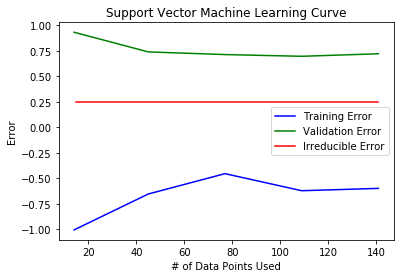

In [9]:
train_sizes, train_scores, valid_scores = learning_curve(SVR(C=1,gamma=0.01,kernel='rbf'),X_train,y_train,cv=5,
                                                         scoring =make_scorer(mean_squared_error,greater_is_better=False),
                                                         n_jobs=-1 )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
#----Plotting
plt.plot(train_sizes,train_mean,'b',label="Training Error")
plt.plot(train_sizes,valid_mean*-1,'g',label="Validation Error")
plt.plot(np.linspace(15,141,30),[.25 for i in range(30)],'r',label="Irreducible Error")
plt.xlabel("# of Data Points Used")
plt.ylabel("Error")
plt.title("Support Vector Machine Learning Curve")
plt.legend()
plt.show()

**Random Forest Regressor Overview**

The next best model I believed that would work best is the Random Forest Regressor (RFR) because with it using ensemble predictions it could produce better results than the SVM. Unlike the SVM I don't have any intuition on what the parameters will be best for the RFR, so I tests lots of different parameters using GridSearchCV. 

In [10]:
rfparams = {'max_depth':[i for i in range(1,12)],'max_features': ['auto', 'sqrt'],'random_state':[7],
            "min_samples_leaf":[i for i in range(1,10)],'n_estimators': [200, 400]}
rfrgrid = GridSearchCV(RandomForestRegressor(),rfparams,cv=5,scoring = make_scorer(mean_squared_error,
                                                                                   greater_is_better=False),iid=False,
                       n_jobs=-1).fit(X_train,y_train)
print(rfrgrid.best_params_)
print(rfrgrid.best_score_*-1)
mean_squared_error(y_test,rfrgrid.predict(X_test))

{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 400, 'random_state': 7}
0.7854964404615266


0.8866102291400664

**Random Forest Regressor Results** 

The best parameters for the RFR are max_depth=7,max_features='sqrt',min_samples_leaf = 5, and n_estimators = 400. The average MSE error during training is ~0.78 while the test MSE is ~0.88. Again like the SVM the RFR is overfitting the training data. You can see there is the divit in the learning curve graph below just like the SVM again it is around ~80 data points. Similarly to the SVM I only trained the RFR on 80 data points and the traing MSE was close to what it is now. 


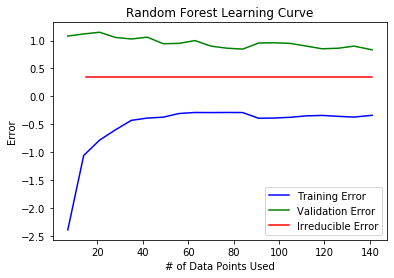

In [11]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(max_depth=12,random_state=7,
                                                                               min_samples_leaf=4),
                                                         X_train,y_train,cv=5,scoring =make_scorer(mean_squared_error,
                                                                                                   greater_is_better=False),
                                                         train_sizes =np.linspace(0.05,1.0,20),n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
#----Plotting
plt.plot(train_sizes,train_mean,'b',label="Training Error")
plt.plot(train_sizes,valid_mean*-1,'g',label="Validation Error")
plt.plot(np.linspace(15,141,30),[.35 for i in range(30)],'r',label="Irreducible Error")
plt.xlabel("# of Data Points Used")
plt.ylabel("Error")
plt.title("Random Forest Learning Curve")
plt.legend()

plt.show()

**Multi-Layered Perceptron Overview**

To me neither the SVM nor the RFR generalizes well enough for this dataset. I believed that a multi-layered perceptron would give me more controll on overfitting the data or not. Note that I did not use GridSearchCV to find the best combination of # of hidden layers and neurons in them, I just played around with them for a while till it gave me the best results. Since I believe the dataset is kinda complex I believed that 1000 neurons in the first hidden layer would work best. The rest of the layers are just half of the previous layers' neuron count. That is similar to a wildly used machine learning convention of reducing the number of neurons for each consecutive hidden layer till you get to the output layer(i.e. converging at 1 neuron)

In [12]:
mlpparams = {'hidden_layer_sizes' : [(1000, 500, 250, 125,50)],'activation':['logistic'],'solver':['adam'],"learning_rate":['adaptive']}
mlpgrid = GridSearchCV(MLPRegressor(random_state=7),mlpparams,cv=5,scoring = make_scorer(mean_squared_error,greater_is_better=False),iid=False,n_jobs=-1).fit(X_train,y_train)
print(mlpgrid.best_params_)
print(mlpgrid.best_score_*-1)
mean_squared_error(y_test,mlpgrid.predict(X_test))

{'activation': 'logistic', 'hidden_layer_sizes': (1000, 500, 250, 125, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.7662301101002685


C:\Users\pirat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.3548476205473076

**Multi-Layered Perceptron Results**

The best hyper parameters for the MLP are; activation = logistic, hidden_layer_sizes=(1000,500,250,125,50), learning_rate = adaptive, and solver = adam. The average MSE during training was ~0.76, so very similar to both the SVM and RFR, albet the MSE for testing is ~0.35! Amazing! The MLP generalized amazingly! When looking at the learning curve for the MLP I would say it still has not converged to the irreducible error, but that is only speculative only more data points could tell us if that was true. 

In [13]:
train_sizes, train_scores, valid_scores = learning_curve(MLPRegressor(hidden_layer_sizes=(1000, 500, 250, 125,50),
                                                                      activation='logistic',solver='adam',learning_rate="adaptive",
                                                                      random_state=7),
                                                         X_train,y_train,cv=5,
                                                         scoring =make_scorer(mean_squared_error,greater_is_better=False),n_jobs=-1,
                                                        train_sizes =np.linspace(0.05,1.0,20))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
#----Plotting


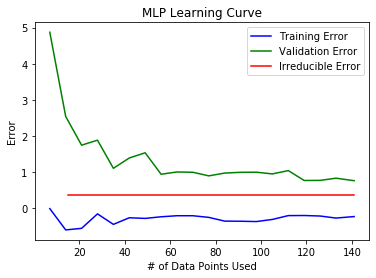

In [14]:
plt.plot(train_sizes,train_mean,'b',label="Training Error")
plt.plot(train_sizes,valid_mean*-1,'g',label="Validation Error")
plt.plot(np.linspace(15,141,30),[.35 for i in range(30)],'r',label="Irreducible Error")
plt.xlabel("# of Data Points Used")
plt.ylabel("Error")
plt.title("MLP Learning Curve")
plt.legend()

# plt.gca().invert_yaxis()
plt.show()

# Result Explaination
Obviously, I will choose the MLP model as my best model because it has a average MSE for training in comparison to the other two models. Well now let me clairfy weither the MLP is the best of the best or the best of the worse models or it is just a good model. If that didn't make sense let me elporate. 

The MSE of the MLP model is 0.35 so what does that really mean? It means that on average the MLP's prediction was off from the true value by 0.35. Well is that good or bad? Let's look at the true vsini values and the predicted vsini values.

In [15]:
y_test

array([-0.28907341,  1.56980521, -0.43492388,  0.13989858, -0.6751482 ,
       -0.2661949 , -0.20327901,  4.14363715, -0.43206407, -0.62653137,
       -0.14608275, -0.65798932, -0.60651268,  1.36961828, -0.09746592,
        0.50881449, -0.44064351, -0.28907341, -0.48926034, -0.11748461])

In [16]:
MLPprediction = mlpgrid.predict(X_test)
MLPprediction

array([-0.18926676,  0.49310329, -0.35222744,  0.49771282, -0.43296615,
       -0.41838203, -0.18032383,  3.51171391,  0.02886408, -0.51798793,
        0.44928553, -0.65092014, -0.33664722,  0.03011861,  0.3354973 ,
       -0.23687313, -0.61194246,  1.14854246, -0.6077377 , -0.00929968])

There are some values that are much less than 0.35 but then there are predictions that are factors away from the true values. If you take notice the true values that are much larger tend to have the worse predictions given to them. So, what if I take away these out liers? Well we get pretty much the exact same MSE. To me these results are very poor. Although some are very close to the true values the outliers are far from decent. 

# Future Improvements
Collect my own data then I will be determining the full width half maximums for the data so I know they are all calculated using the same techiqnue. The data I used are called cross-correlation functions. I speculate that the models will find an easier time finding the correlaction between the width & height of the gaussian to the vsini value if I calculate the data myself. Although it will take some time, I just need ~200 samples, based off the learning curves. 